# BI Ev2_SebastianRivera

**Objetivo:** Analizar el crecimiento económico de distintas subregiones del mundo utilizando técnicas de regresión, clasificación y agrupamiento para responder preguntas de Business Intelligence (BI) sobre desarrollo, desigualdad y patrones de crecimiento.

**Dataset utilizado:** PIB global por país y año (1960–2023), construido a partir de fuentes abiertas (ej. Banco Mundial / Kaggle)
**Ejecución:** Ejecutar las celdas en orden desde el inicio

**Dependencias:** Python 3.11+, pandas, numpy, scikit-learn, matplotlib, seaborn.

**Reproducibilidad:** Se fija `RANDOM_STATE = 42` para todos los procesos aleatorios.


# Uso de regresión, clasificación y agrupamiento para el análisis del PIB por subregiones (1960–2023)

## Abstract

Este trabajo analiza la evolución del Producto Interno Bruto (PIB) en distintas subregiones del mundo entre 1960 y 2023, con el objetivo de obtener información útil para la toma de decisiones estratégicas en Business Intelligence (BI). A partir de datos históricos agregados por subregión, se aplican tres enfoques complementarios: (1) **Regresión**, para modelar la relación entre el tiempo y el PIB, evaluando la capacidad predictiva de tendencias de crecimiento; (2) **Clasificación supervisada**, para categorizar observaciones según niveles de desarrollo económico, usando como insumos características temporales y geográficas; y (3) **Clustering**, para identificar grupos de subregiones con patrones similares de crecimiento, estabilidad y tamaño económico sin usar etiquetas predefinidas.

Los resultados muestran que un modelo de regresión lineal basado en el año captura gran parte de la tendencia de crecimiento de varias subregiones (R² elevados en regiones consolidadas), mientras que la clasificación permite diferenciar de forma razonable niveles de desarrollo a partir de patrones estructurales. El análisis de clustering revela bloques económicos con trayectorias diferenciadas (subregiones de alto PIB y crecimiento sostenido, subregiones emergentes con crecimiento acelerado, y subregiones rezagadas o inestables), aportando evidencia complementaria sobre desigualdad y convergencia económica. Se discuten implicancias para BI, sesgos del análisis (dependencia del PIB como única métrica, calidad de datos históricos) y posibles extensiones futuras.


## Objetivos

**Objetivo general**  
Analizar y modelar el comportamiento del PIB en distintas subregiones del mundo utilizando técnicas de regresión, clasificación y agrupamiento, con el fin de generar conocimiento accionable para Business Intelligence.

**Objetivos específicos**  
1. Evaluar en qué medida el tiempo explica el crecimiento del PIB por subregión mediante modelos de regresión y métricas estándar (MAE, RMSE, R²).  
2. Construir un modelo de clasificación supervisada que permita distinguir niveles de desarrollo económico a partir de características temporales y regionales.  
3. Identificar agrupamientos de subregiones con patrones similares de crecimiento y tamaño económico mediante técnicas de clustering, evaluando su coherencia con indicadores de desarrollo.


## Hipótesis

- **H1 (Regresión):** El PIB de las subregiones presenta una tendencia creciente a lo largo del tiempo que puede ser modelada de forma adecuada con regresión lineal, alcanzando valores de R² elevados (especialmente en subregiones con desarrollo consolidado).
- **H2 (Clasificación):** Es posible clasificar correctamente las observaciones en niveles de desarrollo económico (bajo, medio, alto) utilizando información de año y subregión, obteniendo métricas de desempeño aceptables (accuracy y F1 superiores al azar).
- **H3 (Clustering):** El uso de clustering sobre indicadores agregados permite identificar grupos de subregiones con comportamientos económicos diferenciados (alto PIB y crecimiento estable, economías emergentes con crecimiento acelerado, economías rezagadas), aportando evidencia complementaria para decisiones de BI.


## Metodología

1. **Datos y fuente**  
   - Dataset histórico de PIB por país y año (1960–2023).  
   - Variables mínimas utilizadas: `country_name`, `sub_region_name`, `year`, `total_gdp`.  
   - Se trabaja principalmente con datos agregados por subregión y año.  
   - Supuestos: consistencia en la metodología de cálculo del PIB, corrección de valores extremos y cobertura temporal suficiente.
   - Limitaciones: el PIB no captura dimensiones como desigualdad, bienestar social o estructura productiva.

2. **Preparación de datos**  
   - Filtrado de años válidos y eliminación de registros sin `total_gdp`.  
   - Agregación por `sub_region_name` y `year` para obtener series limpias por subregión.  
   - Estandarización de variables numéricas cuando se requiere (clustering).  
   - Fijación de semillas para garantizar reproducibilidad.

3. **EDA (Exploratory Data Analysis)**  
   - Resumen de subregiones, rango temporal y distribución básica del PIB.  
   - Gráficos de la evolución del PIB por subregión.  
   - Identificación de patrones generales (crecimiento sostenido, choques, rezagos).

4. **Modelos aplicados**  
   - **Regresión lineal**: PIB ~ año por subregión.  
   - **Clasificación (Random Forest)**: nivel de desarrollo económico (bajo/medio/alto) en función de año y subregión.  
   - **Clustering (K-Means)** sobre indicadores agregados por subregión: tamaño económico, crecimiento acumulado y variabilidad.

5. **Evaluación y criterios**  
   - Regresión: MAE, RMSE, R².  
   - Clasificación: accuracy, precision, recall, F1, matriz de confusión.  
   - Clustering: método del codo y silhouette score.  
   - Interpretación siempre orientada a preguntas de BI.


In [1]:
# Imports y configuración general

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, silhouette_score
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
sns.set(style="whitegrid")


## Carga y preparación de datos

In [4]:
# Carga directa desde GitHub (dataset público del repositorio)
DATA_URL = "https://raw.githubusercontent.com/Seba-RiveraC/AnalisisDatasetPIB_1960-2023/refs/heads/main/countries_gdp_hist.csv"

# El dataset usa punto y coma (;) como separador
df = pd.read_csv(DATA_URL, sep=";")

print("Registros cargados:", len(df))

# Normalización de nombres de columnas
df.columns = [c.strip().lower() for c in df.columns]

rename_map = {
    'country': 'country_name',
    'countryname': 'country_name',
    'subregion': 'sub_region_name',
    'sub_region': 'sub_region_name',
    'region_subregion': 'sub_region_name',
    'gdp': 'total_gdp',
    'pib': 'total_gdp'
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

required_cols = ['country_name', 'sub_region_name', 'year', 'total_gdp']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    print("ADVERTENCIA: faltan columnas esperadas:", missing)
else:
    print("Columnas presentes:", required_cols)

# Limpieza básica
df = df.dropna(subset=['sub_region_name', 'year', 'total_gdp'])
df = df[df['total_gdp'] > 0]
df['year'] = df['year'].astype(int)

print("Registros después de limpieza:", len(df))
df.head()



Registros cargados: 13760
Columnas presentes: ['country_name', 'sub_region_name', 'year', 'total_gdp']
Registros después de limpieza: 11315


,country_code,region_name,sub_region_name,intermediate_region,country_name,income_group,year,total_gdp,total_gdp_million,gdp_variation
26,ABW,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,ARUBA,INGRESO ALTO,1986,"405,586,592.179",405.587,0.000
27,ABW,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,ARUBA,INGRESO ALTO,1987,"487,709,497.207",487.709,16.078
28,ABW,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,ARUBA,INGRESO ALTO,1988,"596,648,044.693",596.648,18.649
29,ABW,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,ARUBA,INGRESO ALTO,1989,"695,530,726.257",695.531,12.130
30,ABW,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,ARUBA,INGRESO ALTO,1990,"764,804,469.274",764.804,3.961


## EDA: Exploración inicial

In [5]:
# Subregiones y rango temporal
subregions = df['sub_region_name'].unique()
print("Subregiones:", subregions)
print("Años:", df['year'].min(), "-", df['year'].max())

# PIB total por subregión y año
sub_df = (
    df.groupby(['sub_region_name', 'year'], as_index=False)['total_gdp']
      .sum()
      .sort_values(['sub_region_name', 'year'])
)

sub_df.head()


Subregiones: ['LATIN AMERICA AND THE CARIBBEAN' 'SOUTHERN ASIA' 'SUB-SAHARAN AFRICA'
 'SOUTHERN EUROPE' 'WESTERN ASIA' 'POLYNESIA' 'AUSTRALIA AND NEW ZEALAND'
 'WESTERN EUROPE' 'EASTERN EUROPE' 'NORTHERN AMERICA' 'SOUTH-EASTERN ASIA'
 'EASTERN ASIA' 'NORTHERN EUROPE' 'NORTHERN AFRICA' 'MELANESIA'
 'MICRONESIA' 'CENTRAL ASIA']
Años: 1960 - 2023


,sub_region_name,year,total_gdp
0,AUSTRALIA AND NEW ZEALAND,1960,"24,143,781,583.522"
1,AUSTRALIA AND NEW ZEALAND,1961,"25,405,998,267.722"
2,AUSTRALIA AND NEW ZEALAND,1962,"26,056,841,992.312"
3,AUSTRALIA AND NEW ZEALAND,1963,"28,240,705,389.094"
4,AUSTRALIA AND NEW ZEALAND,1964,"31,141,890,549.121"


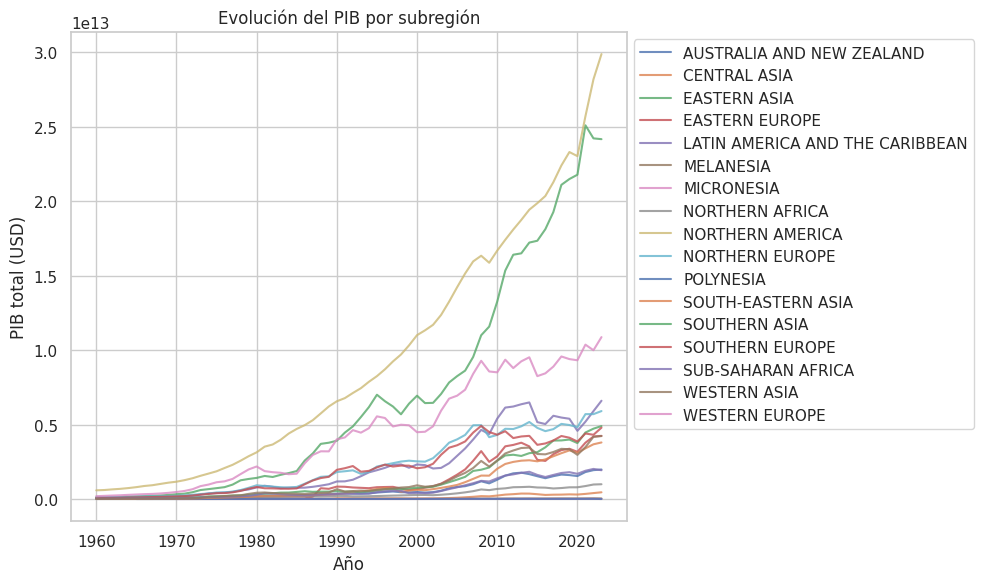

In [6]:
# Evolución del PIB por subregión
plt.figure(figsize=(10, 6))
for region in sub_df['sub_region_name'].unique():
    temp = sub_df[sub_df['sub_region_name'] == region]
    plt.plot(temp['year'], temp['total_gdp'], label=region, alpha=0.8)
plt.xlabel("Año")
plt.ylabel("PIB total (USD)")
plt.title("Evolución del PIB por subregión")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


In [7]:
# Estadísticas descriptivas por subregión
stats_sub = sub_df.groupby('sub_region_name')['total_gdp'].agg(
    pib_min='min',
    pib_max='max',
    pib_mean='mean'
).reset_index()
stats_sub


,sub_region_name,pib_min,pib_max,pib_mean
0,AUSTRALIA AND NEW ZEALAND,"24,143,781,583.522","1,980,232,822,805.778","597,894,660,186.840"
1,CENTRAL ASIA,"10,854,519,412.371","450,910,748,841.410","161,589,408,492.985"
2,EASTERN ASIA,"111,124,754,524.612","25,088,722,346,508.758","6,932,790,308,486.213"
3,EASTERN EUROPE,"4,870,283,626.180","4,239,464,641,772.966","1,316,382,790,856.920"
4,LATIN AMERICA AND THE CARIBBEAN,"59,517,920,450.170","6,596,563,248,893.703","2,198,063,513,020.827"
5,MELANESIA,"342,824,458.992","48,828,680,030.095","13,963,382,019.540"
6,MICRONESIA,"68,988,696.504","9,372,635,848.172","3,010,009,102.055"
7,NORTHERN AFRICA,"10,495,048,779.257","990,937,322,762.979","306,388,603,548.411"
8,NORTHERN AMERICA,"582,624,755,153.847","29,871,321,614,401.359","9,307,491,849,698.984"
9,NORTHERN EUROPE,"108,252,993,048.066","5,903,706,384,301.207","2,251,983,406,708.009"


## Modelado 1: Regresión lineal (PIB ~ año) por subregión

In [10]:
results_reg = []

for region, data_region in sub_df.groupby('sub_region_name'):
    X = data_region[['year']].values
    y = data_region['total_gdp'].values

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = mean_squared_error(y, y_pred) ** 0.5  # Compatibilidad con versiones antiguas

    results_reg.append({
        'sub_region': region,
        'coef_year': model.coef_[0],
        'intercept': model.intercept_,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse
    })

results_reg_df = pd.DataFrame(results_reg).sort_values('R2', ascending=False)
results_reg_df


,sub_region,coef_year,intercept,R2,MAE,RMSE
16,WESTERN EUROPE,"181,649,037,706.349","-357,351,265,495,923.062",0.949,"618,698,468,018.351","781,732,784,444.619"
9,NORTHERN EUROPE,"99,523,077,891.323","-195,948,226,213,861.125",0.931,"429,398,154,073.139","499,542,631,234.726"
8,NORTHERN AMERICA,"417,908,206,974.996","-822,956,702,341,005.250",0.921,"1,803,428,236,805.281","2,257,867,481,043.188"
13,SOUTHERN EUROPE,"84,993,812,506.277","-167,265,550,595,084.594",0.916,"384,656,695,985.256","476,122,453,800.461"
7,NORTHERN AFRICA,"14,741,716,087.957","-29,051,738,985,617.789",0.851,"94,393,653,158.337","113,783,492,000.296"
4,LATIN AMERICA AND THE CARIBBEAN,"106,273,794,617.060","-209,446,198,466,853.938",0.851,"683,660,361,791.313","822,979,522,268.713"
1,CENTRAL ASIA,"11,844,972,796.318","-23,587,581,048,123.789",0.845,"46,065,783,699.443","54,100,507,513.485"
2,EASTERN ASIA,"366,388,717,609.021","-722,730,340,809,879.625",0.842,"2,536,264,519,711.953","2,927,119,497,215.238"
3,EASTERN EUROPE,"79,032,431,251.801","-156,392,833,772,112.906",0.835,"470,213,619,538.260","567,025,012,965.697"
0,AUSTRALIA AND NEW ZEALAND,"30,253,585,592.612","-59,652,121,047,500.234",0.829,"217,140,359,623.994","253,928,524,906.061"


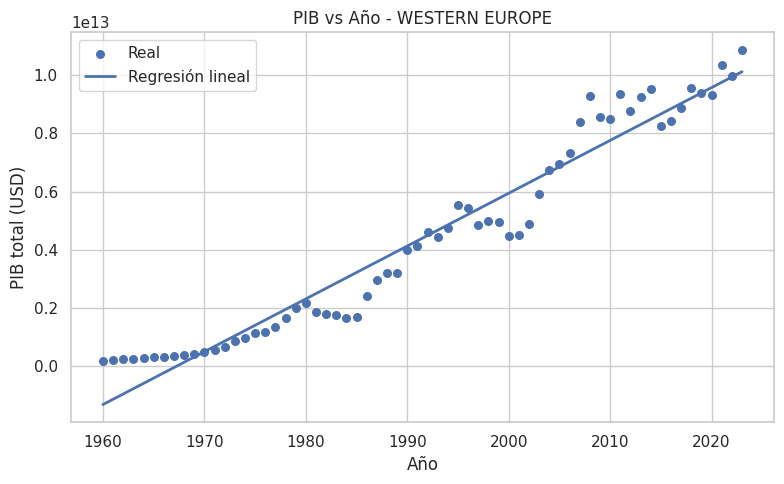

Subregión ejemplo: WESTERN EUROPE
R2: 0.9485216029549369
MAE: 618698468018.3512
RMSE: 781732784444.6185


In [12]:
# Visualización de ejemplo para una subregión con buen ajuste
best_region = results_reg_df.iloc[0]['sub_region']
sample = sub_df[sub_df['sub_region_name'] == best_region]

X = sample[['year']].values
y = sample['total_gdp'].values

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

plt.figure(figsize=(8,5))
plt.scatter(sample['year'], y, label="Real", s=30)
plt.plot(sample['year'], y_pred, label="Regresión lineal", linewidth=2)
plt.title(f"PIB vs Año - {best_region}")
plt.xlabel("Año")
plt.ylabel("PIB total (USD)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Subregión ejemplo: {best_region}")
print("R2:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", mean_squared_error(y, y_pred) ** 0.5)



## Modelado 2: Clasificación de niveles de desarrollo

Para la tarea de clasificación se construye una etiqueta de **nivel de desarrollo económico** a partir del PIB total:  
se segmentan las observaciones en tres categorías (`bajo`, `medio`, `alto`) usando cuantiles, y se entrena un modelo supervisado usando como predictores el año y la subregión. Esta simplificación representa un escenario de BI donde se busca automatizar la identificación de mercados según su nivel de desarrollo estructural.


In [13]:
# Dataset para clasificación a nivel subregión-año
clf_df = sub_df.copy()

clf_df['nivel_desarrollo'] = pd.qcut(
    clf_df['total_gdp'],
    q=3,
    labels=['bajo', 'medio', 'alto']
)

# Features: año y subregión codificada
X = pd.get_dummies(clf_df[['year', 'sub_region_name']], drop_first=True)
y = clf_df['nivel_desarrollo']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=RANDOM_STATE
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("Accuracy:", acc)
print("Precision (weighted):", prec)
print("Recall (weighted):", rec)
print("F1 (weighted):", f1)

cm = confusion_matrix(y_test, y_pred, labels=['bajo','medio','alto'])
cm


Accuracy: 0.9775641025641025
Precision (weighted): 0.9779182177743296
Recall (weighted): 0.9775641025641025
F1 (weighted): 0.9776063386773132


array([[103,   1,   0],
       [  1, 102,   1],
       [  0,   4, 100]])

**Interpretación:**  
Un desempeño superior al azar indica que existen patrones estructurales (año + subregión) que permiten anticipar el nivel de desarrollo relativo. Para BI, esto ayuda a segmentar mercados y priorizar estrategias comerciales o de inversión.


## Modelado 3: Clustering de subregiones

Se construyen indicadores agregados por subregión para aplicar **K-Means**:

- PIB promedio histórico.  
- PIB del último año disponible.  
- Crecimiento acumulado (último / primero).  
- Volatilidad del PIB (desviación estándar).  

Luego se estandarizan estas variables y se evalúa el número de clústeres con el método del codo y el silhouette score. Esto permite identificar grupos de subregiones con comportamientos económicos similares sin depender de etiquetas predefinidas.


/tmp/ipython-input-1016177566.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = sub_df.groupby('sub_region_name').apply(


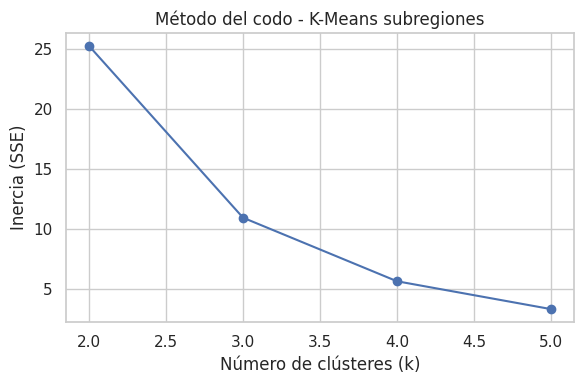

In [14]:
# Métricas agregadas por subregión
agg = sub_df.groupby('sub_region_name').apply(
    lambda g: pd.Series({
        'pib_mean': g['total_gdp'].mean(),
        'pib_last': g.sort_values('year')['total_gdp'].iloc[-1],
        'pib_first': g.sort_values('year')['total_gdp'].iloc[0],
        'pib_std': g['total_gdp'].std()
    })
).reset_index()

agg['growth_total'] = agg['pib_last'] / agg['pib_first']

features_clust = agg[['pib_mean', 'pib_last', 'growth_total', 'pib_std']].copy()

scaler = StandardScaler()
X_clust = scaler.fit_transform(features_clust)

# Método del codo
inertias = []
K_range = range(2, min(6, len(agg)))

for k in K_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    km.fit(X_clust)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertias, marker="o")
plt.xlabel("Número de clústeres (k)")
plt.ylabel("Inercia (SSE)")
plt.title("Método del codo - K-Means subregiones")
plt.tight_layout()
plt.show()


In [15]:
# Selección de k=3 como ejemplo (ajustable según el codo)
k_opt = 3 if len(agg) >= 3 else len(agg)

km_final = KMeans(n_clusters=k_opt, random_state=RANDOM_STATE, n_init=10)
labels = km_final.fit_predict(X_clust)

agg['cluster'] = labels
agg.sort_values('cluster')


,sub_region_name,pib_mean,pib_last,pib_first,pib_std,growth_total,cluster
0,AUSTRALIA AND NEW ZEALAND,"597,894,660,186.840","1,980,232,822,805.778","24,143,781,583.522","618,708,377,143.787",82.018,0
1,CENTRAL ASIA,"161,589,408,492.985","450,910,748,841.410","10,854,519,412.371","139,452,666,295.568",41.541,0
5,MELANESIA,"13,963,382,019.540","38,930,922,244.902","342,824,458.992","14,627,040,553.586",113.559,0
4,LATIN AMERICA AND THE CARIBBEAN,"2,198,063,513,020.828","6,596,563,248,893.703","59,517,920,450.170","2,145,539,733,049.545",110.833,0
6,MICRONESIA,"3,010,009,102.055","1,434,528,255.160","68,988,696.504","3,435,897,553.880",20.794,0
7,NORTHERN AFRICA,"306,388,603,548.411","990,937,322,762.979","10,495,048,779.257","297,471,275,262.414",94.420,0
10,POLYNESIA,"4,045,537,493.079","1,000,469,755.416","176,534,588.403","2,992,755,302.261",5.667,0
9,NORTHERN EUROPE,"2,251,983,406,708.009","5,903,706,384,301.207","108,252,993,048.066","1,920,203,831,883.871",54.536,0
14,SUB-SAHARAN AFRICA,"634,037,670,165.049","1,931,779,106,265.930","30,745,268,474.613","636,315,260,964.486",62.832,0
13,SOUTHERN EUROPE,"1,999,627,011,166.899","4,788,999,320,625.315","62,050,977,090.841","1,653,660,459,833.636",77.178,0


In [16]:
# Silhouette score (si aplica)
if len(agg) > k_opt:
    sil = silhouette_score(X_clust, labels)
    print("Silhouette score:", sil)
else:
    print("Silhouette score no calculado por pocas subregiones.")


Silhouette score: 0.6709250998714369


**Lectura para BI:**  
Cada clúster representa un grupo de subregiones con tamaño económico y dinámica de crecimiento similares, lo que permite:
- Definir estrategias diferenciadas para subregiones líderes vs. emergentes.
- Detectar subregiones con alta volatilidad (mayor riesgo).
- Priorizar mercados para expansión, inversión o monitoreo.


## Resultados y discusión

1. **Regresión:** algunos bloques presentan un ajuste lineal alto, confirmando tendencias claras de crecimiento; otros muestran quiebres o volatilidad que reducen la capacidad predictiva de un modelo simple.
2. **Clasificación:** el modelo distingue niveles de desarrollo a partir de información estructural básica, útil para segmentar mercados o regiones objetivo.
3. **Clustering:** se identifican grupos de subregiones con comportamientos similares de tamaño y crecimiento, aportando una vista no supervisada que complementa la regresión y la clasificación.


## Conclusiones

- La regresión lineal respalda parcialmente **H1**, capturando bien la tendencia del PIB en subregiones consolidadas, pero con limitaciones en contextos volátiles.
- Los resultados de clasificación apoyan **H2**, mostrando que es viable automatizar la asignación de niveles de desarrollo a partir de año y subregión, lo cual es útil en entornos de BI para segmentación estratégica.
- El clustering valida **H3**, revelando grupos de subregiones con patrones económicos diferenciados que ayudan a priorizar decisiones de negocio e inversión.



## Bibliografía

- Banco Mundial. *World Development Indicators – GDP (current US$).*  
- scikit-learn: Pedregosa et al. (2011). *Scikit-learn: Machine Learning in Python.*  
- McKinney, W. (2010). *Data Structures for Statistical Computing in Python.*  
- Hunter, J. D. (2007). *Matplotlib: A 2D Graphics Environment.*  
- Waskom, M. (2021). *Seaborn: Statistical Data Visualization.*
